In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import cv2
import imageio.v2 as imageio
import numpy as np
import pandas as pd
from IPython.display import display, Math, Video
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import os
from os import listdir
from os.path import isfile, isdir, join
import time

startInstantTime = time.time()

In [2]:
#Parametros de ejecucion del programa
nombreArchivoInformacion = "InformacionEjercicioRegresion.txt"
nombreArchivoDataset = "DatasetRegresion.csv"
nombreArchivoAnimacion = "Animación del ADALINE"
tasaAprendizaje = 0.000001
tiempoPausaAnimacion = 0.001

searchFolderPath = "./Figuras/"
imageFileExtension = ".jpg"
animationFileExtension = ".mp4"
framesPorSegundoAnimacion = 20

colorTextoVerde = (35, 155, 86)
colorTextoRojo = (176, 58, 46)

In [3]:
imageFileExtensionsList = [imageFileExtension]

def printColouredText(text, foregroundColor = (0, 0, 0), backgroundColor = (255, 255, 255)):
    return "\033[48;2;{};{};{}m\033[38;2;{};{};{}m{}\033[38;2;0;0;0m\033[48;2;255;255;255m".format(backgroundColor[0], backgroundColor[1], backgroundColor[2], foregroundColor[0], foregroundColor[1], foregroundColor[2], text)

def getFilesListOfSomeExtensionAtSomeDirectory(searchFolderPath, fileExtensionsList):
    informativeMessage = ""
    filesList = [file for file in listdir(searchFolderPath) if isfile(join(searchFolderPath, file))]
    filesList = [file for file in filesList if file[len(file) - 4:] in fileExtensionsList]
    filesList.sort(key = lambda file: os.path.getmtime(join(searchFolderPath, file)))
    numberFilesFound = len(filesList)
    if numberFilesFound == 0:
        informativeMessage = "No hay archivos con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    elif numberFilesFound == 1:
        informativeMessage = "Solo hay un archivo con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    else:
        informativeMessage = "Hay " + str(numberFilesFound) + " archivos con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    return filesList, informativeMessage

def deleteFilesOfSomeExtensionAtSomeDirectory(searchFolderPath, fileExtensionsList):
    informativeMessage = ""
    filesList = [file for file in listdir(searchFolderPath) if isfile(join(searchFolderPath, file))]
    filesList = [file for file in filesList if file[len(file) - 4:] in fileExtensionsList]
    numberFilesFound = len(filesList)
    if numberFilesFound == 0:
        informativeMessage = "No hay archivos con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    elif numberFilesFound == 1:
        informativeMessage = "Solo hay un archivo con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    else:
        informativeMessage = "Hay " + str(numberFilesFound) + " archivos con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    
    for file in filesList:
        os.remove(join(searchFolderPath, file))
    return informativeMessage

def resizeImage(image, width = None, height = None, interpolationTechnique = cv2.INTER_AREA):
    newImageSize = None
    ratioFactor = 1.0
    (imageHeight, imageWidth) = image.shape[:2]
    
    #The ratio factor is computed (only in case to get exactly one of the parameters (width or height) in None), otherwise, the image will be resized without keep its aspect ratio
    if width is None and height is None:
        return image
    if width is None:
        ratioFactor = height / float(imageHeight)
        newImageSize = (int(imageWidth * ratioFactor), height)
    elif height is None:
        ratioFactor = width / float(imageWidth)
        newImageSize = (width, int(imageHeight * ratioFactor))
    else:
        newImageSize = (width, height)
    resizedImage = cv2.resize(image, newImageSize, interpolation = interpolationTechnique)
    return resizedImage

#El ajuste de tamaño comun a las imagenes esta hecho con reescalado al tamaño maximo/minimo o con un slice/recorte al tamaño minimo
def overwriteFittedImagesToCommonSize(searchFolderPath, imageFilesList):
    numberImageFilesFound = len(imageFilesList)
    if numberImageFilesFound >= 1:
        maximumWidthForAllImages = -1
        maximumHeightForAllImages = -1
        #minimumWidthForAllImages = float('inf')
        #minimumHeightForAllImages = float('inf')
        for imageFile in imageFilesList:
            originalImage = cv2.imread(join(searchFolderPath, imageFile), -1)
            originalImageWidth = originalImage.shape[1]
            originalImageHeight = originalImage.shape[0]
            if originalImageWidth > maximumWidthForAllImages:
                maximumWidthForAllImages = originalImageWidth
            if originalImageHeight > maximumHeightForAllImages:
                maximumHeightForAllImages = originalImageHeight
            #if originalImageWidth < minimumWidthForAllImages:
                #minimumWidthForAllImages = originalImageWidth
            #if originalImageHeight < minimumHeightForAllImages:
                #minimumHeightForAllImages = originalImageHeight
                
        for imageFile in imageFilesList:
            originalImage = cv2.imread(join(searchFolderPath, imageFile), -1)
            originalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
            originalImage = resizeImage(originalImage, width = maximumWidthForAllImages, height = maximumHeightForAllImages)
            #originalImage = originalImage[0:minimumHeightForAllImages, 0:minimumWidthForAllImages]
            cv2.imwrite(join(searchFolderPath, imageFile), originalImage)
        print("Se han ajustado " + printColouredText(str(numberImageFilesFound) + " imágen(es)", colorTextoVerde) + " a un tamaño común que es de " + printColouredText(str(maximumWidthForAllImages) + "x" + str(maximumHeightForAllImages), colorTextoVerde) + " como máximo de ancho por máximo de alto")
        #print("Se han ajustado " + printColouredText(str(numberImageFilesFound) + " imágen(es)", colorTextoVerde) + " a un tamaño común que es de " + printColouredText(str(minimumWidthForAllImages) + "x" + str(minimumHeightForAllImages), colorTextoVerde) + " como mínimo de ancho por mínimo de alto")
    else:
        print(printColouredText("La lista dada está vacía", colorTextoRojo))

def createAnimationFromImageFilesAtSomeDirectory(searchFolderPath, imageFileExtensionsList, animationFilename, animationFileExtension, frameRate):
    imageFilesList, informativeMessage = getFilesListOfSomeExtensionAtSomeDirectory(searchFolderPath, imageFileExtensionsList)
    overwriteFittedImagesToCommonSize(searchFolderPath, imageFilesList)
    animationFilePath = join(searchFolderPath, animationFilename + animationFileExtension)
    
    writerStream = imageio.get_writer(animationFilePath, fps = frameRate)
    for imageFile in imageFilesList:
        writerStream.append_data(imageio.imread(join(searchFolderPath, imageFile)))
    writerStream.close()
    print("Se ha creado el archivo", printColouredText(animationFilePath, colorTextoVerde))
    return animationFilePath

def obtenerListasCoordenadasRespectivas(listaPuntos, numeroDimensiones):
    diccionarioPuntosPorCoordenadas = {}
    for indice in range(numeroDimensiones):
        diccionarioPuntosPorCoordenadas[indice] = []
    
    for puntoActual in listaPuntos:
        for indice in range(numeroDimensiones):
            coordenadaActual = puntoActual[indice]
            diccionarioPuntosPorCoordenadas[indice].append(coordenadaActual)
    return diccionarioPuntosPorCoordenadas

def crearTextoEcuacionHiperplano(listaCoeficientesHiperplano):
    numeroDimensionesEspacio = len(listaCoeficientesHiperplano) - 1
    diccionarioCoeficientesPrincipalesNoNulos = {}
    for indice in range(numeroDimensionesEspacio):
        if listaCoeficientesHiperplano[indice] != 0.0:
            diccionarioCoeficientesPrincipalesNoNulos[indice] = listaCoeficientesHiperplano[indice]
    
    textoEcuacionHiperplano = ''
    indiceNuevoCoeficienteNoNulo = 0
    if numeroDimensionesEspacio <= 3:
        for indice in diccionarioCoeficientesPrincipalesNoNulos.keys():
            if indiceNuevoCoeficienteNoNulo == 0:
                if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                    textoEcuacionHiperplano = r'' + chr(indice + 120)
                elif diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                    textoEcuacionHiperplano = r'-' + chr(indice + 120)
                else:
                    textoEcuacionHiperplano = r'{}'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
            else:
                if diccionarioCoeficientesPrincipalesNoNulos[indice] > 0.0:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                        textoEcuacionHiperplano += ' + ' + chr(indice + 120)
                    else:
                        textoEcuacionHiperplano += ' + {}'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
                else:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                        textoEcuacionHiperplano += ' - ' + chr(indice + 120)
                    else:
                        textoEcuacionHiperplano += ' - {}'.format(-diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
            indiceNuevoCoeficienteNoNulo += 1
    else:
        for indice in diccionarioCoeficientesPrincipalesNoNulos.keys():
            if indiceNuevoCoeficienteNoNulo == 0:
                if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                    textoEcuacionHiperplano = r'x_{' + str(indice + 1) + '}'
                elif diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                    textoEcuacionHiperplano = r'-x_{' + str(indice + 1) + '}'
                else:
                    textoEcuacionHiperplano = r'{}x'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
            else:
                if diccionarioCoeficientesPrincipalesNoNulos[indice] > 0.0:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                        textoEcuacionHiperplano += ' + x_{' + str(indice + 1) + '}'
                    else:
                        textoEcuacionHiperplano += ' + {}x'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                else:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                        textoEcuacionHiperplano += ' - x_{' + str(indice + 1) + '}'
                    else:
                        textoEcuacionHiperplano += ' - {}x'.format(-diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
            indiceNuevoCoeficienteNoNulo += 1

    if listaCoeficientesHiperplano[numeroDimensionesEspacio] > 0.0:
        textoEcuacionHiperplano += ' + {}'.format(listaCoeficientesHiperplano[numeroDimensionesEspacio])
    elif listaCoeficientesHiperplano[numeroDimensionesEspacio] < 0.0:
        textoEcuacionHiperplano += ' - {}'.format(-listaCoeficientesHiperplano[numeroDimensionesEspacio])
    textoEcuacionHiperplano += ' = 0'
    return textoEcuacionHiperplano

def crearTextoFuncionLineal(listaCoeficientesFuncionLineal):
    numeroDimensionesEspacio = len(listaCoeficientesFuncionLineal)
    diccionarioCoeficientesPrincipalesNoNulos = {}
    for indice in range(numeroDimensionesEspacio - 1):
        if listaCoeficientesFuncionLineal[indice] != 0.0:
            diccionarioCoeficientesPrincipalesNoNulos[indice] = listaCoeficientesFuncionLineal[indice]
    
    textoEncabezadoFuncion = r'f \left('
    if numeroDimensionesEspacio <= 3:
        for indice in range(numeroDimensionesEspacio - 1):
            if indice == numeroDimensionesEspacio - 2:
                textoEncabezadoFuncion += chr(indice + 120)
            else:
                textoEncabezadoFuncion += chr(indice + 120) + ', '
    else:
        for indice in range(numeroDimensionesEspacio - 1):
            if indice == numeroDimensionesEspacio - 2:
                textoEncabezadoFuncion += r'x_{' + str(indice + 1) + '}'
            else:
                textoEncabezadoFuncion += r'x_{' + str(indice + 1) + '}, '
    textoEncabezadoFuncion += r' \right) = '
    
    textoFuncionLineal = ''
    if listaCoeficientesFuncionLineal[0:(numeroDimensionesEspacio - 1)] == [0.0] * (numeroDimensionesEspacio - 1):
        textoFuncionLineal = '{}'.format(listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1])
    else:
        indiceNuevoCoeficienteNoNulo = 0
        if numeroDimensionesEspacio <= 3:
            for indice in diccionarioCoeficientesPrincipalesNoNulos.keys():
                if indiceNuevoCoeficienteNoNulo == 0:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                        textoFuncionLineal = r'' + chr(indice + 120)
                    elif diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                        textoFuncionLineal = r'-' + chr(indice + 120)
                    else:
                        textoFuncionLineal = r'{}'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
                else:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] > 0.0:
                        if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                            textoFuncionLineal += ' + ' + chr(indice + 120)
                        else:
                            textoFuncionLineal += ' + {}'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
                    else:
                        if diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                            textoFuncionLineal += ' - ' + chr(indice + 120)
                        else:
                            textoFuncionLineal += ' - {}'.format(-diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
                indiceNuevoCoeficienteNoNulo += 1
        else:
            for indice in diccionarioCoeficientesPrincipalesNoNulos.keys():
                if indiceNuevoCoeficienteNoNulo == 0:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                        textoFuncionLineal = r'x_{' + str(indice + 1) + '}'
                    elif diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                        textoFuncionLineal = r'-x_{' + str(indice + 1) + '}'
                    else:
                        textoFuncionLineal = r'{}x'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                else:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] > 0.0:
                        if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                            textoFuncionLineal += ' + x_{' + str(indice + 1) + '}'
                        else:
                            textoFuncionLineal += ' + {}x'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                    else:
                        if diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                            textoFuncionLineal += ' - x_{' + str(indice + 1) + '}'
                        else:
                            textoFuncionLineal += ' - {}x'.format(-diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                indiceNuevoCoeficienteNoNulo += 1
        
        if listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1] > 0.0:
            textoFuncionLineal += ' + {}'.format(listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1])
        elif listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1] < 0.0:
            textoFuncionLineal += ' - {}'.format(-listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1])
    return textoEncabezadoFuncion + textoFuncionLineal

def evaluarPuntoRespectoAFuncionLineal(listaCoeficientesFuncionLineal, abscisasPunto):
    numeroDimensionesVectoresEntrada = len(listaCoeficientesFuncionLineal) - 1
    return np.dot(listaCoeficientesFuncionLineal[0:numeroDimensionesVectoresEntrada], abscisasPunto) + listaCoeficientesFuncionLineal[numeroDimensionesVectoresEntrada]

In [4]:
def actualizarHiperplanoRegresion(listaCoeficientesFuncionLinealInicial, listaVectoresAbscisas, listaValoresSalida, tasaAprendizaje):
    numeroDimensionesVectoresEntrada = len(listaCoeficientesFuncionLinealInicial) - 1
    listaCoeficientesFuncionLinealActualizada = listaCoeficientesFuncionLinealInicial
    
    indicePuntoActual = 0
    for abscisasPunto in listaVectoresAbscisas:
        valorPuntoActual = evaluarPuntoRespectoAFuncionLineal(listaCoeficientesFuncionLinealActualizada, abscisasPunto)
        errorPuntoActual = listaValoresSalida[indicePuntoActual] - valorPuntoActual
        for indice in range(numeroDimensionesVectoresEntrada):
            listaCoeficientesFuncionLinealActualizada[indice] += tasaAprendizaje * errorPuntoActual * abscisasPunto[indice]
        listaCoeficientesFuncionLinealActualizada[numeroDimensionesVectoresEntrada] += tasaAprendizaje * errorPuntoActual
        indicePuntoActual += 1
    return listaCoeficientesFuncionLinealActualizada

def calcularValoresSalidaModeloYError(listaCoeficientesFuncionLineal, listaVectoresAbscisas, listaValoresSalida):
    listaValoresSalidaModelo = []
    for punto in listaVectoresAbscisas:
        valorSalidaModelo = evaluarPuntoRespectoAFuncionLineal(listaCoeficientesFuncionLineal, punto)
        listaValoresSalidaModelo.append(valorSalidaModelo)
    listaErroresModelo = np.array(np.abs(listaValoresSalida - listaValoresSalidaModelo))
    return listaValoresSalidaModelo, listaErroresModelo

def verificarRegresionCorrecta(listaValoresSalida, listaValoresSalidaModelo, maximoErrorCuadraticoMedioPermitido):
    errorCuadraticoMedio = mean_squared_error(listaValoresSalida, listaValoresSalidaModelo, squared = False)
    return errorCuadraticoMedio < maximoErrorCuadraticoMedioPermitido, errorCuadraticoMedio

def algoritmoADALINE(listaCoeficientesFuncionLinealInicial, listaCoeficientesFuncionLinealMinimoError, listaPuntosMuestra, listaVectoresAbscisas, listaValoresSalida, maximoErrorCuadraticoMedioPermitido, tasaAprendizaje, numeroDimensiones):
    listaCoeficientesFuncionLinealActualizada = listaCoeficientesFuncionLinealInicial
    listaValoresSalidaModelo, listaErroresModelo = calcularValoresSalidaModeloYError(listaCoeficientesFuncionLinealActualizada, listaVectoresAbscisas, listaValoresSalida)
    regresionCompletada, errorCuadraticoMedio = verificarRegresionCorrecta(listaValoresSalida, listaValoresSalidaModelo, maximoErrorCuadraticoMedioPermitido)
    listaCoeficientesCorrelacion = [np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))]
    listaErroresCuadraticosMedios = [errorCuadraticoMedio]
    listaErroresTipicosTotales = [np.sum(listaErroresModelo)]
    listaErroresTipicosMedios = [np.mean(listaErroresModelo)]
    print("Error en la iteracion 0 = " + str(errorCuadraticoMedio))
    
    numeroPasos = 0
    if regresionCompletada == False:
        mensajeConfirmacion = deleteFilesOfSomeExtensionAtSomeDirectory(searchFolderPath, imageFileExtensionsList)
        print(printColouredText(mensajeConfirmacion, colorTextoRojo))
        if numeroDimensiones == 2:
            plt.ion()
            while regresionCompletada == False:
                plt.clf()
                listaCoeficientesFuncionLinealActualizada = actualizarHiperplanoRegresion(listaCoeficientesFuncionLinealActualizada, listaVectoresAbscisas, listaValoresSalida, tasaAprendizaje)
                listaValoresSalidaModelo, listaErroresModelo = calcularValoresSalidaModeloYError(listaCoeficientesFuncionLinealActualizada, listaVectoresAbscisas, listaValoresSalida)
                regresionCompletada, errorCuadraticoMedio = verificarRegresionCorrecta(listaValoresSalida, listaValoresSalidaModelo, maximoErrorCuadraticoMedioPermitido)
                coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))
                errorTipicoTotal = np.sum(listaErroresModelo)
                errorTipicoMedio = np.mean(listaErroresModelo)
                listaCoeficientesCorrelacion.append(coeficienteCorrelacion)
                listaErroresCuadraticosMedios.append(errorCuadraticoMedio)
                listaErroresTipicosTotales.append(errorTipicoTotal)
                listaErroresTipicosMedios.append(errorTipicoMedio)
                print("Error en la iteracion " + str(numeroPasos) + " = " + str(errorCuadraticoMedio))
                print(listaCoeficientesFuncionLinealActualizada)
                
                listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
                listaValoresCoordenadaYHiperplanoBase = [listaCoeficientesHiperplanoBase[0] * valorX + listaCoeficientesHiperplanoBase[1] for valorX in listaValoresCoordenadaXHiperplanoBase]

                plt.plot(valoresCoordenadasXPuntosMuestra, valoresCoordenadasYPuntosMuestra, 'ro', label = "Puntos de Muestra")
                plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'b-', label = "Modelo de Regresión Lineal Propuesto (Algoritmo Adaline)")
                plt.legend(loc = 'upper left')
                plt.xlabel("Eje X")
                plt.ylabel("Eje Y")
                plt.title("Visualización de la Recta de Regresión que proporciona el Algoritmo Adaline")
                plt.grid(True)

                numeroPasos += 1
                plt.pause(tiempoPausaAnimacion)
            plt.ioff()
            plt.show()
        elif numeroDimensiones == 3:
            listaPuntosPorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(listaPuntosMuestra, numeroDimensiones)
            valoresCoordenadasXPuntos = listaPuntosPorCoordenadasRespectivas[0]
            valoresCoordenadasYPuntos = listaPuntosPorCoordenadasRespectivas[1]
            valoresCoordenadasZPuntos = listaPuntosPorCoordenadasRespectivas[2]
            minimoEjeX = np.min(valoresCoordenadasXPuntos) - 1
            maximoEjeX = np.max(valoresCoordenadasXPuntos) + 1
            minimoEjeY = np.min(valoresCoordenadasYPuntos) - 1
            maximoEjeY = np.max(valoresCoordenadasYPuntos) + 1
            minimoEjeZ = np.min(valoresCoordenadasZPuntos) + 1
            maximoEjeZ = np.max(valoresCoordenadasZPuntos) + 1
            
            listaValoresCoordenadaXHiperplanoMinimoError = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
            listaValoresCoordenadaYHiperplanoMinimoError = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoRegresion)
            listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError = np.meshgrid(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError)
            listaValoresCoordenadaZHiperplanoMinimoError = listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 1]
            
            currentFigure = plt.figure(num = 2, figsize = (9, 8))
            ax = currentFigure.gca(projection = '3d')
            ax.view_init(elev = 7, azim = 122) #Se ajusta la perspectiva manualmente de forma que se pueda visualizar los planos de separacion, los vectores de soporte y evidencia que separen los datos segun la clase a la que pertenecen (Si se cambia de plano para generar los puntos de muestra, se recomienda ajustar adecuadamente la perspectiva)
            plt.ion()
            while regresionCompletada == False:
                ax.cla()
                listaCoeficientesFuncionLinealActualizada = actualizarHiperplanoRegresion(listaCoeficientesFuncionLinealInicial, listaVectoresAbscisas, listaValoresSalida, tasaAprendizaje)
                listaValoresSalidaModelo, listaErroresModelo = calcularValoresSalidaModeloYError(listaCoeficientesFuncionLinealActualizada, listaVectoresAbscisas, listaValoresSalida)
                regresionCompletada, errorCuadraticoMedio = verificarRegresionCorrecta(listaValoresSalida, listaValoresSalidaModelo, maximoErrorCuadraticoMedioPermitido)
                coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))
                errorTipicoTotal = np.sum(listaErroresModelo)
                errorTipicoMedio = np.mean(listaErroresModelo)
                listaCoeficientesCorrelacion.append(coeficienteCorrelacion)
                listaErroresCuadraticosMedios.append(errorCuadraticoMedio)
                listaErroresTipicosTotales.append(errorTipicoTotal)
                listaErroresTipicosMedios.append(errorTipicoMedio)
                print("Error en la iteracion " + str(numeroPasos) + " = " + str(errorCuadraticoMedio))
                print(listaCoeficientesFuncionLinealActualizada)
                
                valoresCoordenadasZPuntos = listaPuntosPorCoordenadasRespectivas[2]
                minimoEjeZ = np.min(valoresCoordenadasZPuntos) - 1
                maximoEjeZ = np.max(valoresCoordenadasZPuntos) + 1

                listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
                listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoRegresion)
                listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
                listaValoresCoordenadaZHiperplanoBase = listaCoeficientesFuncionLinealActualizada[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesFuncionLinealActualizada[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesFuncionLinealActualizada[numeroDimensiones - 1]
                
                ax.scatter(valoresCoordenadasXPuntos, valoresCoordenadasYPuntos, valoresCoordenadasZPuntos, c = 'r', marker = 'o')
                etiquetaLeyendaPuntos = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
                ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'b', alpha = 0.35)
                etiquetaLeyendaPlano = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'b')
                ax.plot_surface(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError, listaValoresCoordenadaZHiperplanoMinimoError, color = 'g', alpha = 0.35)
                etiquetaLeyendaPlanoMinimoError = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
                ax.set_xlabel("Eje X")
                ax.set_ylabel("Eje Y")
                ax.set_zlabel("Eje Z")
                ax.set_title("Visualización del Plano de Regresión que proporciona el Algoritmo Adaline")
                ax.legend([etiquetaLeyendaPuntos, etiquetaLeyendaPlano, etiquetaLeyendaPlanoMinimoError], ["Puntos de Muestra", "Plano de Regresión Lineal Propuesto (Algoritmo Adaline)", "Plano de Regresión Lineal de Mínimo Error"], numpoints = 1)
                plt.tight_layout()
                
                numeroPasos += 1
                plt.pause(tiempoPausaAnimacion)
                plt.show()
            plt.ioff()
            plt.show()
    return listaCoeficientesFuncionLinealActualizada, listaCoeficientesCorrelacion, listaErroresCuadraticosMedios, listaErroresTipicosTotales, listaErroresTipicosMedios

In [5]:
numeroDimensiones = None
listaCoeficientesFuncionLinealBase = []
etiquetaCoordenadaPuntos = None
nombreColumnaValorFuncion = None

inputStream = open(nombreArchivoInformacion, "r")
lineasTextoArchivo = inputStream.readlines()
for numeroLineaActual in range(len(lineasTextoArchivo)):
    if numeroLineaActual == 0:
        numeroDimensiones = int(lineasTextoArchivo[numeroLineaActual].strip())
    elif numeroLineaActual == 1:
        lineaTextoActual = lineasTextoArchivo[numeroLineaActual].strip()
        lineaTextoActual = lineaTextoActual[1:(len(lineaTextoActual) - 1)]
        datosCoeficientesHiperplano = lineaTextoActual.split(", ")
        for coeficiente in datosCoeficientesHiperplano:
            listaCoeficientesFuncionLinealBase.append(float(coeficiente))
    elif numeroLineaActual == 2:
        etiquetaCoordenadaPuntos = lineasTextoArchivo[numeroLineaActual].strip()
    elif numeroLineaActual == 3:
        nombreColumnaValorFuncion = lineasTextoArchivo[numeroLineaActual].strip()
inputStream.close()

print("Se ha extraído la información del archivo", printColouredText(nombreArchivoInformacion, colorTextoVerde))
print("Se está trabajando sobre", printColouredText(str(numeroDimensiones) + " dimension(es)", colorTextoVerde))
print("Los coeficientes del hiperplano (Función lineal) sobre el cual se generó el dataset de puntos para regresión son:", printColouredText(str(listaCoeficientesFuncionLinealBase), colorTextoRojo))

Se ha extraído la información del archivo InformacionEjercicioRegresion.txt
Se está trabajando sobre 3 dimension(es)
Los coeficientes del hiperplano (Función lineal) sobre el cual se generó el dataset de puntos para regresión son: [7.673073113240619, 2.3239683152061357, -4.688331685883391]


In [6]:
datasetFile = pd.read_csv(nombreArchivoDataset)

listaAbscisasPuntosMuestra = []
listaPuntosMuestra = []
for indicefilaActual, filaActual in datasetFile.iterrows():
    puntoActual = []
    for indice in range(numeroDimensiones - 1):
        nombreColumnaActual = "Coordenada $" + etiquetaCoordenadaPuntos + "_{" + str(indice + 1) + "}$"
        puntoActual.append(filaActual[nombreColumnaActual])
    listaAbscisasPuntosMuestra.append(puntoActual)
    valorFuncionPuntoActual = filaActual[nombreColumnaValorFuncion]
    listaPuntosMuestra.append(puntoActual + [valorFuncionPuntoActual])

print("Se ha extraído la información del archivo", printColouredText(nombreArchivoDataset, colorTextoVerde))
print("Se tiene un total de", printColouredText(str(len(listaPuntosMuestra)) + " punto(s)", colorTextoVerde))

Se ha extraído la información del archivo DatasetRegresion.csv
Se tiene un total de 1000 punto(s)


In [7]:
#Esta parte se puede comentar para que no se proponga inicialmente un hiperplano de coeficientes aleatorios sino para que el hiperplano propuesto inicialmente separe perfectamente las muestras de las 2 clases y por lo tanto no se realizaran iteraciones del algoritmo del perceptron simple
listaCoeficientesFuncionLinealBase = list(np.random.uniform(low = -50.0, high = 50.0, size = numeroDimensiones))

listaCoeficientesHiperplanoRegresionBase = []
for indice in range(numeroDimensiones):
    if indice == numeroDimensiones - 1:
        listaCoeficientesHiperplanoRegresionBase.append(1.0)
    listaCoeficientesHiperplanoRegresionBase.append(-listaCoeficientesFuncionLinealBase[indice])
textoEcuacionHiperplanoRegresionBase = crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoRegresionBase)
if numeroDimensiones == 2:
    print("La recta propuesta inicialmente para ejecutar el algoritmo ADALINE, está dada por la ecuación:")
elif numeroDimensiones == 3:
    print("El plano propuesto inicialmente para ejecutar el algoritmo ADALINE, está dado por la ecuación:")
elif numeroDimensiones >= 4:
    print("El hiperplano propuesto inicialmente para ejecutar el algoritmo ADALINE, está dado por la ecuación:")
display(Math(textoEcuacionHiperplanoRegresionBase))

textoFuncionLinealBase = crearTextoFuncionLineal(listaCoeficientesFuncionLinealBase)
if numeroDimensiones == 2:
    print("Como función, la recta propuesta inicialmente para ejecutar el algoritmo ADALINE, es:")
elif numeroDimensiones == 3:
    print("Como función, el plano propuesto inicialmente para ejecutar el algoritmo ADALINE, es:")
elif numeroDimensiones >= 4:
    print("Como función, el hiperplano propuesto inicialmente para ejecutar el algoritmo ADALINE, es:")
display(Math(textoFuncionLinealBase))

El plano propuesto inicialmente para ejecutar el algoritmo ADALINE, está dado por la ecuación:


<IPython.core.display.Math object>

Como función, el plano propuesto inicialmente para ejecutar el algoritmo ADALINE, es:


<IPython.core.display.Math object>

In [8]:
listaVariablesEntrada = []
for indice in range(numeroDimensiones - 1):
    nombreColumnaActual = "Coordenada $" + etiquetaCoordenadaPuntos + "_{" + str(indice + 1) + "}$"
    listaVariablesEntrada.append(nombreColumnaActual)

#Se toman las variables necesarias del conjunto de datos y se realiza el entrenamiento del modelo de regresion lineal
listaValoresEntradaX = datasetFile[listaVariablesEntrada]
listaValoresSalidaY = datasetFile[nombreColumnaValorFuncion]
modeladorRegresionLineal = linear_model.LinearRegression()
modeladorRegresionLineal.fit(listaValoresEntradaX, listaValoresSalidaY)
listaValoresSalidaModelo = modeladorRegresionLineal.predict(listaValoresEntradaX)

In [9]:
#Se muestran los resultados del modelo de regresion lineal junto al error obtenido en una tabla comparativa de resultados
listaErroresModelo = np.abs(np.array(listaValoresSalidaY.tolist()) - np.array(listaValoresSalidaModelo.tolist()))
listaValoresSalidaModeloBase, listaErroresModeloBase = calcularValoresSalidaModeloYError(listaCoeficientesFuncionLinealBase, listaAbscisasPuntosMuestra, np.array(listaValoresSalidaY.tolist()))

informacionTablaResultados = {}
for indice in range(numeroDimensiones - 1):
    nombreColumnaActual = "Coordenada $" + etiquetaCoordenadaPuntos + "_{" + str(indice + 1) + "}$"
    informacionTablaResultados[nombreColumnaActual] = datasetFile[nombreColumnaActual].tolist()
informacionTablaResultados[nombreColumnaValorFuncion + ' (Real)'] = listaValoresSalidaY.tolist()
informacionTablaResultados[nombreColumnaValorFuncion + ' (Modelo Mínimo ECM)'] = listaValoresSalidaModelo.tolist()
informacionTablaResultados['Error (Modelo Mínimo ECM)'] = listaErroresModelo
informacionTablaResultados[nombreColumnaValorFuncion + ' (Modelo Base)'] = listaValoresSalidaModeloBase
informacionTablaResultados['Error (Modelo Base'] = listaErroresModeloBase
display(pd.DataFrame(informacionTablaResultados))

,Coordenada $x_{1}$,Coordenada $x_{2}$,Valor de la Función (Real),Valor de la Función (Modelo Mínimo ECM),Error (Modelo Mínimo ECM),Valor de la Función (Modelo Base),Error (Modelo Base
0,13.952232,10.162483,165.455514,125.320925,40.134589,541.415913,375.960399
1,10.221277,2.074934,120.454338,77.821845,42.632492,305.379837,184.925499
2,-7.852147,15.763789,-25.207055,-26.384778,1.177723,-56.627745,31.420689
3,8.508690,19.890098,90.575157,107.280929,16.705772,515.222636,424.647479
4,-16.770370,-5.873184,-177.165954,-145.412227,31.753727,-654.902214,477.736259
...,...,...,...,...,...,...,...
995,-9.947999,-13.121849,-77.765426,-111.032500,33.267074,-549.015286,471.249861
996,12.918409,9.749678,103.844982,116.512625,12.667644,503.033666,399.188684
997,15.052645,6.780663,91.232835,125.597353,34.364519,525.790797,434.557963
998,-4.343104,-12.272075,-60.360951,-66.583889,6.222939,-361.444321,301.083370


In [10]:
#Se muestra la informacion de desempeño del modelo de regresion lineal
coeficienteCorrelacionModeloMinimoError = np.sqrt(r2_score(listaValoresSalidaY, listaValoresSalidaModelo))
minimoErrorCuadraticoMedio = mean_squared_error(listaValoresSalidaY, listaValoresSalidaModelo, squared = False)
minimoErrorTipicoTotal = np.sum(listaErroresModelo)
minimoErrorTipicoMedio = np.mean(listaErroresModelo)
print("El coeficiente de correlación del modelo de mínimo error es:", printColouredText(str(coeficienteCorrelacionModeloMinimoError), colorTextoVerde))
print("El error típico total del modelo de mínimo error es:", printColouredText(str(minimoErrorTipicoTotal), colorTextoRojo))
print("El error típico medio del modelo de mínimo error es:", printColouredText(str(minimoErrorTipicoMedio), colorTextoRojo))
print("El error cuadrático medio del modelo de mínimo error es:", printColouredText(str(minimoErrorCuadraticoMedio), colorTextoRojo))

#Se indica la formula matematica del modelo (funcion lineal) que relaciona las variables de entrada con la variable de salida
listaCoeficientesFuncionLinealMinimoError = list(np.array(modeladorRegresionLineal.coef_)) + list([modeladorRegresionLineal.intercept_])

#Se muestra la informacion de desempeño del modelo base
coeficienteCorrelacionModeloBase = np.sqrt(r2_score(listaValoresSalidaY, listaValoresSalidaModeloBase))
errorCuadraticoMedioModeloBase = mean_squared_error(listaValoresSalidaY, listaValoresSalidaModeloBase, squared = False)
errorTipicoTotalModeloBase = np.sum(listaErroresModeloBase)
errorTipicoMedioModeloBase = np.mean(listaErroresModeloBase)
print("\nEl coeficiente de correlación del modelo base es:", printColouredText(str(coeficienteCorrelacionModeloBase), colorTextoVerde))
print("El error típico total del modelo base es:", printColouredText(str(errorTipicoTotalModeloBase), colorTextoRojo))
print("El error típico medio del modelo base es:", printColouredText(str(errorTipicoMedioModeloBase), colorTextoRojo))
print("El error cuadrático medio del modelo base es:", printColouredText(str(errorCuadraticoMedioModeloBase), colorTextoRojo))

El coeficiente de correlación del modelo de mínimo error es: 0.9521716297422838
El error típico total del modelo de mínimo error es: 25512.399139982357
El error típico medio del modelo de mínimo error es: 25.512399139982357
El error cuadrático medio del modelo de mínimo error es: 29.30894878302491

El coeficiente de correlación del modelo base es: nan
El error típico total del modelo base es: 259367.13975222013
El error típico medio del modelo base es: 259.3671397522201
El error cuadrático medio del modelo base es: 311.7901969794358


/tmp/ipykernel_11121/3688902912.py:15: RuntimeWarning: invalid value encountered in sqrt
  coeficienteCorrelacionModeloBase = np.sqrt(r2_score(listaValoresSalidaY, listaValoresSalidaModeloBase))


In [11]:
listaCoeficientesHiperplanoRegresionMinimoError = []
for indice in range(numeroDimensiones):
    if indice == numeroDimensiones - 1:
        listaCoeficientesHiperplanoRegresionMinimoError.append(1.0)
    listaCoeficientesHiperplanoRegresionMinimoError.append(-listaCoeficientesFuncionLinealMinimoError[indice])
textoEcuacionHiperplanoRegresionMinimoError = crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoRegresionMinimoError)
if numeroDimensiones == 2:
    print("El modelo de regresión (que da la recta de mínimo error) está dada por la ecuación:")
elif numeroDimensiones == 3:
    print("El modelo de regresión (que da el plano de mínimo error) está dado por la ecuación:")
elif numeroDimensiones >= 4:
    print("El modelo de regresión (que da el hiperplano de mínimo error) está dado por la ecuación:")
display(Math(textoEcuacionHiperplanoRegresionMinimoError))

textoFuncionLinealRegresionMinimoError = crearTextoFuncionLineal(listaCoeficientesFuncionLinealMinimoError)
if numeroDimensiones == 2:
    print("Como función, el modelo de regresión (que da la recta de mínimo error) es:")
elif numeroDimensiones == 3:
    print("Como función, el modelo de regresión (que da el plano de mínimo error) es:")
elif numeroDimensiones >= 4:
    print("Como función, el modelo de regresión (que da el hiperplano de mínimo error) es:")
display(Math(textoFuncionLinealRegresionMinimoError))

El modelo de regresión (que da el plano de mínimo error) está dado por la ecuación:


<IPython.core.display.Math object>

Como función, el modelo de regresión (que da el plano de mínimo error) es:


<IPython.core.display.Math object>

<IPython.core.display.Javascript object>


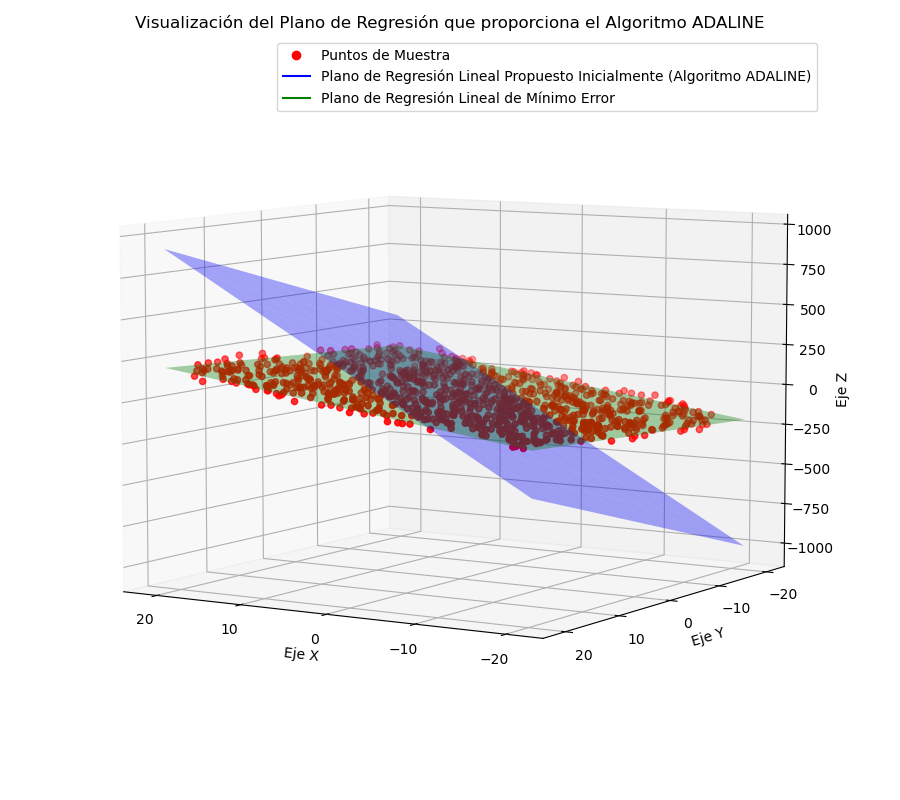

/tmp/ipykernel_11121/1877497478.py:46: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')


In [12]:
%matplotlib notebook

listaPuntosPorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(listaPuntosMuestra, numeroDimensiones)
valoresCoordenadasXPuntos = listaPuntosPorCoordenadasRespectivas[0]
valoresCoordenadasYPuntos = listaPuntosPorCoordenadasRespectivas[1]
valoresCoordenadasZPuntos = None
minimoEjeX = np.min(valoresCoordenadasXPuntos) - 1
maximoEjeX = np.max(valoresCoordenadasXPuntos) + 1
minimoEjeY = np.min(valoresCoordenadasYPuntos) - 1
maximoEjeY = np.max(valoresCoordenadasYPuntos) + 1
minimoEjeZ = None
maximoEjeZ = None

numeroMuestrasHiperplanoRegresion = 10
if numeroDimensiones == 2:
    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaYHiperplanoBase = listaCoeficientesFuncionLinealBase[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesFuncionLinealBase[numeroDimensiones - 1]
    listaValoresCoordenadaXHiperplanoMinimoError = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaYHiperplanoMinimoError = listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 1]
    
    plt.figure(num = 1, figsize = (9, 8))
    plt.plot(valoresCoordenadasXPuntos, valoresCoordenadasYPuntos, 'ro', label = "Puntos de Muestra")
    plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'b-', label = "Recta de Regresión Lineal Propuesto Inicialmente (Algoritmo ADALINE)")
    plt.plot(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError, 'g-', label = "Recta de Regresión Lineal de Mínimo Error")
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")
    plt.title("Visualización de la Recta de Regresión que proporciona el Algoritmo ADALINE")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 3:
    valoresCoordenadasZPuntos = listaPuntosPorCoordenadasRespectivas[2]
    minimoEjeZ = np.min(valoresCoordenadasZPuntos) - 1
    maximoEjeZ = np.max(valoresCoordenadasZPuntos) + 1
    
    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
    listaValoresCoordenadaZHiperplanoBase = listaCoeficientesFuncionLinealBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesFuncionLinealBase[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesFuncionLinealBase[numeroDimensiones - 1]
    listaValoresCoordenadaXHiperplanoMinimoError = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaYHiperplanoMinimoError = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError = np.meshgrid(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError)
    listaValoresCoordenadaZHiperplanoMinimoError = listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 1]
    
    currentFigure = plt.figure(num = 1, figsize = (9, 8))
    ax = currentFigure.gca(projection = '3d')
    ax.view_init(elev = 7, azim = 122) #Se ajusta la perspectiva manualmente de forma que se pueda visualizar los planos de separacion, los vectores de soporte y evidencia que separen los datos segun la clase a la que pertenecen (Si se cambia de plano para generar los puntos de muestra, se recomienda ajustar adecuadamente la perspectiva)
    ax.scatter(valoresCoordenadasXPuntos, valoresCoordenadasYPuntos, valoresCoordenadasZPuntos, c = 'r', marker = 'o')
    etiquetaLeyendaPuntos = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'b', alpha = 0.35)
    etiquetaLeyendaPlano = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'b')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError, listaValoresCoordenadaZHiperplanoMinimoError, color = 'g', alpha = 0.35)
    etiquetaLeyendaPlanoMinimoError = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
    ax.set_xlabel("Eje X")
    ax.set_ylabel("Eje Y")
    ax.set_zlabel("Eje Z")
    ax.set_title("Visualización del Plano de Regresión que proporciona el Algoritmo ADALINE")
    ax.legend([etiquetaLeyendaPuntos, etiquetaLeyendaPlano, etiquetaLeyendaPlanoMinimoError], ["Puntos de Muestra", "Plano de Regresión Lineal Propuesto Inicialmente (Algoritmo ADALINE)", "Plano de Regresión Lineal de Mínimo Error"], numpoints = 1)
    plt.tight_layout()
    plt.show()

Error en la iteracion 0 = 311.7901969794358
No hay archivos con extensión ['.jpg'] para eliminar, en la carpeta ./Figuras/


/tmp/ipykernel_11121/2175364278.py:31: RuntimeWarning: invalid value encountered in sqrt
  listaCoeficientesCorrelacion = [np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))]


<IPython.core.display.Javascript object>


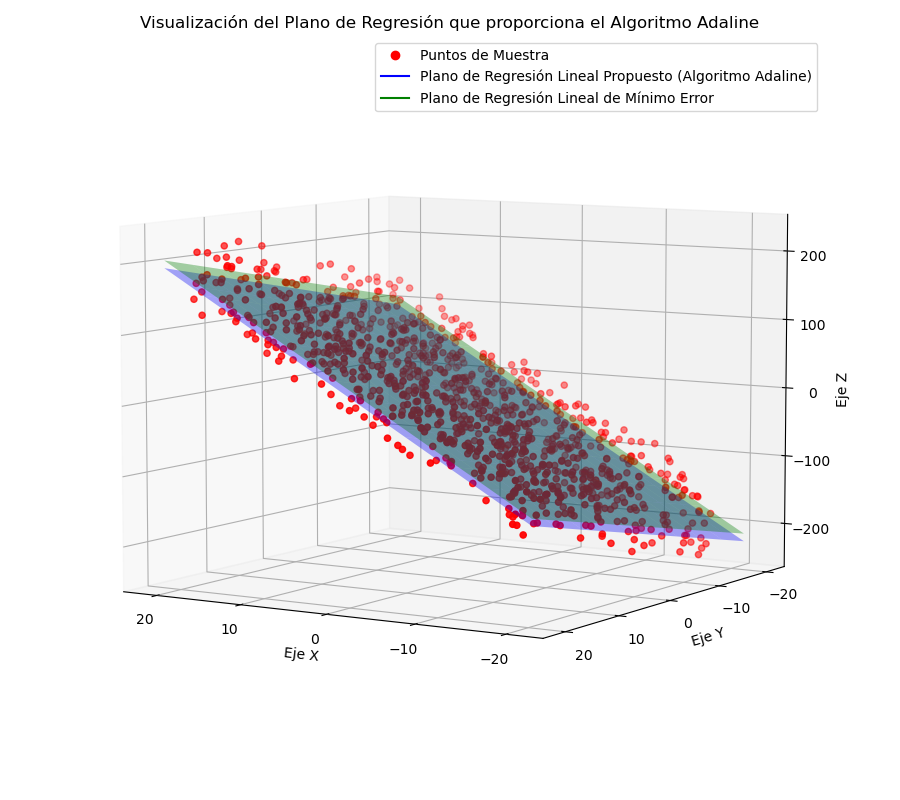

Error en la iteracion 0 = 274.1042412304973
[28.279187025963626, 13.24841511456897, -44.40261460442608]


/tmp/ipykernel_11121/2175364278.py:91: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')
/tmp/ipykernel_11121/2175364278.py:99: RuntimeWarning: invalid value encountered in sqrt
  coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))
/tmp/ipykernel_11121/2175364278.py:99: RuntimeWarning: invalid value encountered in sqrt
  coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))
/tmp/ipykernel_11121/2175364278.py:99: RuntimeWarning: invalid value encountered in sqrt
  coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSal

Error en la iteracion 1 = 241.23985097481406
[25.699232708147115, 11.907284728019642, -44.36096672466804]
Error en la iteracion 2 = 212.61547468417865
[23.439427099738662, 10.733337524716022, -44.31958255473788]
Error en la iteracion 3 = 187.7231778704435
[21.460043671646535, 9.705731588505618, -44.27843452417733]


/tmp/ipykernel_11121/2175364278.py:99: RuntimeWarning: invalid value encountered in sqrt
  coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))


Error en la iteracion 4 = 166.11926672472222
[19.726285499404018, 8.80622320397722, -44.237498446654016]


/tmp/ipykernel_11121/2175364278.py:99: RuntimeWarning: invalid value encountered in sqrt
  coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))


Error en la iteracion 5 = 147.41590444628451
[18.207673552216264, 8.018842966409778, -44.19675310401701]


/tmp/ipykernel_11121/2175364278.py:99: RuntimeWarning: invalid value encountered in sqrt
  coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))
/tmp/ipykernel_11121/2175364278.py:99: RuntimeWarning: invalid value encountered in sqrt
  coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))
/tmp/ipykernel_11121/2175364278.py:99: RuntimeWarning: invalid value encountered in sqrt
  coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))


Error en la iteracion 6 = 131.27355267758836
[16.877510889233434, 7.329612266715173, -44.15617988147347]
Error en la iteracion 7 = 117.39410214311616
[15.712413343662854, 6.7262951184855995, -44.115762447603544]
Error en la iteracion 8 = 105.5146019270963
[14.691898444198364, 6.1981809216093655, -44.07548647370337]
Error en la iteracion 9 = 95.40155895364762
[13.798025347064366, 5.735894306075188, -44.03533938762283]
Error en la iteracion 10 = 86.84585423702926
[13.015079448744228, 5.331228680288006, -43.99531015785889]
Error en la iteracion 11 = 79.65839431397569
[12.329296134950475, 4.977000529005045, -43.95538910418597]
Error en la iteracion 12 = 73.66665595712055
[11.728618809411119, 4.666921874334917, -43.91556773156113]
Error en la iteracion 13 = 68.71225719693741
[11.202486948684449, 4.395488635663753, -43.87583858444543]
Error en la iteracion 14 = 64.64958225974233
[10.741650457072247, 4.157882906604897, -43.836195119029796]
Error en la iteracion 15 = 61.345324505232604
[10.338

Error en la iteracion 86 = 46.88099149036158
[7.493885831477672, 2.483285987256201, -41.104063543666705]
Error en la iteracion 87 = 46.85249268626126
[7.493932031063149, 2.483174272524123, -41.06751496728652]
Error en la iteracion 88 = 46.82403348167237
[7.493981762678357, 2.4830644308093723, -41.03100287377818]
Error en la iteracion 89 = 46.79561383077196
[7.494034578828432, 2.4829562405750742, -40.994527226383894]
Error en la iteracion 90 = 46.76723368843875
[7.494090087552463, 2.482849507898089, -40.95808798842474]
Error en la iteracion 91 = 46.73889301013885
[7.4941479455327995, 2.4827440630257263, -40.92168512329552]
Error en la iteracion 92 = 46.71059175183251
[7.494207852059387, 2.482639757361689, -40.8853185944599]
Error en la iteracion 93 = 46.682329869898304
[7.494269543743153, 2.4825364608279337, -40.84898836544683]
Error en la iteracion 94 = 46.65410732106999
[7.494332789885084, 2.4824340595555374, -40.81269439984611]
Error en la iteracion 95 = 46.62592406238564
[7.49439738

Error en la iteracion 166 = 44.722776858482234
[7.499441879596147, 2.4756733829107933, -38.29252109505681]
Error en la iteracion 167 = 44.697314933528055
[7.499511370817119, 2.475583391355252, -38.25877881472063]
Error en la iteracion 168 = 44.67188934235324
[7.499580792766441, 2.475493489664062, -38.22507021342865]
Error en la iteracion 169 = 44.646500045523034
[7.499650145502171, 2.4754036777423543, -38.191395257564835]
Error en la iteracion 170 = 44.62114700362723
[7.49971942908369, 2.4753139554960013, -38.15775391354701]
Error en la iteracion 171 = 44.59583017727964
[7.499788643571521, 2.475224322831545, -38.12414614782623]
Error en la iteracion 172 = 44.570549527118565
[7.499857789027163, 2.475134779656093, -38.09057192688732]
Error en la iteracion 173 = 44.545305013806235
[7.499926865513015, 2.4750453258772924, -38.05703121724819]
Error en la iteracion 174 = 44.52009659802928
[7.499995873092163, 2.474955961403267, -38.02352398546038]
Error en la iteracion 175 = 44.49492424049838


Error en la iteracion 244 = 42.84289135962594
[7.504659122124076, 2.468917107439101, -35.7592511955556]
Error en la iteracion 245 = 42.82014687489162
[7.504723406600207, 2.46883385982939, -35.72803743753776]
Error en la iteracion 246 = 42.79743571994747
[7.504787626912324, 2.4687506953112632, -35.696854834780474]
Error en la iteracion 247 = 42.7747578572155
[7.504851783124477, 2.468667613801802, -35.66570335618676]
Error en la iteracion 248 = 42.75211324914139
[7.504915875300662, 2.4685846152181474, -35.634582970691014]
Error en la iteracion 249 = 42.729501858193935
[7.504979903504782, 2.4685016994775326, -35.6034936472582]
Error en la iteracion 250 = 42.70692364686563
[7.505043867800708, 2.4684188664972724, -35.572435354884625]
Error en la iteracion 251 = 42.68437857767219
[7.505107768252204, 2.4683361161947546, -35.54140806259732]
Error en la iteracion 252 = 42.661866613152796
[7.505171604923022, 2.4682534484874616, -35.51041173945428]
Error en la iteracion 253 = 42.639387715869965
[

Error en la iteracion 322 = 41.16608543906623
[7.509485409108608, 2.4626671248717633, -33.41581521997297]
Error en la iteracion 323 = 41.14582960648212
[7.509544876342674, 2.462590115531578, -33.386940506115344]
Error en la iteracion 324 = 41.12560424259756
[7.509604284220955, 2.4625131830564038, -33.358094612857606]
Error en la iteracion 325 = 41.1054093116492
[7.509663632802693, 2.462436327369526, -33.329277511433276]
Error en la iteracion 326 = 41.08524477789672
[7.509722922147086, 2.462359548394308, -33.30048917310446]
Error en la iteracion 327 = 41.065110605623005
[7.509782152313218, 2.4622828460541757, -33.27172956916193]
Error en la iteracion 328 = 41.04500675913421
[7.509841323360211, 2.462206220272633, -33.24299867092527]
Error en la iteracion 329 = 41.02493320275954
[7.5099004353470376, 2.4621296709732734, -33.214296449742506]
Error en la iteracion 330 = 41.00488990085145
[7.509959488332676, 2.4620531980797518, -33.18562287699037]
Error en la iteracion 331 = 40.98487681778555

Error en la iteracion 403 = 39.62106882983776
[7.51411490017366, 2.4566719906115853, -31.16793482151114]
Error en la iteracion 404 = 39.603167067456866
[7.51416974659275, 2.456600965170234, -31.141303775316487]
Error en la iteracion 405 = 39.58529295213816
[7.514224538268211, 2.456530010621208, -31.114699310259]
Error en la iteracion 406 = 39.567446450001114
[7.514279275254695, 2.4564591268937574, -31.08812139980739]
Error en la iteracion 407 = 39.5496275271885
[7.514333957606756, 2.4563883139171865, -31.061570017456738]
Error en la iteracion 408 = 39.531836149866585
[7.5143885853789465, 2.456317571620884, -31.035045136728733]
Error en la iteracion 409 = 39.51407228422492
[7.514443158625738, 2.456246899934297, -31.008546731171336]
Error en la iteracion 410 = 39.496335896476566
[7.51449767740157, 2.4561762987869624, -30.98207477435906]
Error en la iteracion 411 = 39.4786269528579
[7.514552141760788, 2.456105768108448, -30.955629239892694]
Error en la iteracion 412 = 39.46094541962873
[7

Error en la iteracion 486 = 38.22623565163846
[7.518485782191488, 2.451011751901913, -29.04562377826308]
Error en la iteracion 487 = 38.21051545846516
[7.51853626592001, 2.4509463760914545, -29.021111065704854]
Error en la iteracion 488 = 38.19482018035993
[7.5185866992594175, 2.4508810655342916, -28.99662281992014]
Error en la iteracion 489 = 38.17914978540304
[7.5186370822599855, 2.450815820165289, -28.972159016487968]
Error en la iteracion 490 = 38.16350424169865
[7.518687414971982, 2.450750639919374, -28.947719631011775]
Error en la iteracion 491 = 38.14788351737488
[7.5187376974455855, 2.450685524731538, -28.9233046391194]
Error en la iteracion 492 = 38.13228758058374
[7.518787929730945, 2.4506204745368665, -28.898914016462964]
Error en la iteracion 493 = 38.11671639950118
[7.518838111878181, 2.4505554892704797, -28.87454773871889]
Error en la iteracion 494 = 38.10116994232708
[7.518888243937302, 2.450490568867568, -28.850205781587867]
Error en la iteracion 495 = 38.08564817728529

Error en la iteracion 569 = 37.00335693188758
[7.522508987804456, 2.4458017498806908, -27.092129342404153]
Error en la iteracion 570 = 36.989598277168845
[7.522555455867215, 2.445741574308225, -27.06956646325282]
Error en la iteracion 571 = 36.975861970239926
[7.522601877549002, 2.445681458798558, -27.04702610469576]
Error en la iteracion 572 = 36.9621479811915
[7.522648252896094, 2.445621403291749, -27.024508244254566]
Error en la iteracion 573 = 36.948456280138814
[7.522694581954757, 2.44556140772788, -27.002012859473275]
Error en la iteracion 574 = 36.93478683722163
[7.522740864771181, 2.4455014720471446, -26.979539927918275]
Error en la iteracion 575 = 36.92113962260436
[7.522787101391539, 2.4454415961897724, -26.957089427178502]
Error en la iteracion 576 = 36.9075146064759
[7.522833291861927, 2.4453817800960382, -26.93466133486513]
Error en la iteracion 577 = 36.89391175904979
[7.52287943622841, 2.4453220237063005, -26.912255628611785]
Error en la iteracion 578 = 36.88033105056414

Error en la iteracion 646 = 36.00717565164548
[7.525954642676709, 2.441339668998992, -25.41906853757417]
Error en la iteracion 647 = 35.99505206772993
[7.525997671542073, 2.4412839471450583, -25.398175583757265]
Error en la iteracion 648 = 35.9829486009476
[7.526040657459208, 2.4412282809085526, -25.37730348373887]
Error en la iteracion 649 = 35.97086522330035
[7.5260836004709715, 2.44117267023396, -25.356452216704277]
Error en la iteracion 650 = 35.958801906815076
[7.526126500620214, 2.441117115065816, -25.335621761859468]
Error en la iteracion 651 = 35.94675862354388
[7.5261693579497235, 2.441061615348729, -25.31481209843138]
Error en la iteracion 652 = 35.93473534556379
[7.526212172502214, 2.4410061710273374, -25.29402320566745]
Error en la iteracion 653 = 35.92273204497706
[7.526254944320379, 2.4409507820463667, -25.273255062835982]
Error en la iteracion 654 = 35.910748693911
[7.52629767344689, 2.4408954483505783, -25.252507649225937]
Error en la iteracion 655 = 35.89878526451804
[

Error en la iteracion 728 = 35.07741526974028
[7.529344101259764, 2.4369503616238672, -23.773294217405326]
Error en la iteracion 729 = 35.06685053938535
[7.529383747018685, 2.436899020851335, -23.754043953575557]
Error en la iteracion 730 = 35.05630371406899
[7.5294233532061705, 2.4368477313233714, -23.734812903932813]
Error en la iteracion 731 = 35.04577476786614
[7.529462919861694, 2.4367964929888046, -23.715601049298943]
Error en la iteracion 732 = 35.0352636748772
[7.529502447024711, 2.436745305796553, -23.696408370514984]
Error en la iteracion 733 = 35.024770409227955
[7.5295419347346355, 2.436694169695559, -23.677234848441]
Error en la iteracion 734 = 35.01429494506958
[7.529581383030861, 2.436643084634847, -23.658080463956043]
Error en la iteracion 735 = 35.003837256578855
[7.529620791952724, 2.436592050563439, -23.638945197958527]
Error en la iteracion 736 = 34.99339731795792
[7.529660161539532, 2.436541067430474, -23.61982903136577]
Error en la iteracion 737 = 34.9829751034343

Error en la iteracion 811 = 34.259138288844525
[7.532503595310341, 2.43285885550338, -22.239180716465256]
Error en la iteracion 812 = 34.24997379492319
[7.5325400874964, 2.4328115985691143, -22.221461691066132]
Error en la iteracion 813 = 34.24082514099994
[7.532576543258658, 2.4327643888032187, -22.20376035148533]
Error en la iteracion 814 = 34.23169230326611
[7.532612962633501, 2.432717226158612, -22.186076680070116]
Error en la iteracion 815 = 34.2225752579386
[7.532649345657217, 2.432670110588263, -22.168410659185493]
Error en la iteracion 816 = 34.21347398125979
[7.532685692366085, 2.432623042045185, -22.150762271214024]
Error en la iteracion 817 = 34.20438844949748
[7.532722002796342, 2.4325760204824394, -22.133131498555734]
Error en la iteracion 818 = 34.1953186389451
[7.5327582769842465, 2.4325290458531343, -22.11551832362848]
Error en la iteracion 819 = 34.18626452592145
[7.532794514965942, 2.4324821181104253, -22.097922728867378]
Error en la iteracion 820 = 34.17722608677091


Error en la iteracion 892 = 33.56614688816873
[7.535344491679738, 2.429179929480051, -20.85976445381658]
Error en la iteracion 893 = 33.55819046569432
[7.5353781482935505, 2.4291363445771634, -20.843422259526672]
Error en la iteracion 894 = 33.550248037111835
[7.535411771313815, 2.4290928031774954, -20.82709637680426]
Error en la iteracion 895 = 33.54231958066838
[7.535445360774064, 2.429049305237625, -20.81078678936834]
Error en la iteracion 896 = 33.53440507463624
[7.53547891670781, 2.429005850714174, -20.79449348095414]
Error en la iteracion 897 = 33.52650449731296
[7.535512439148521, 2.4289624395638123, -20.77821643531321]
Error en la iteracion 898 = 33.51861782702123
[7.535545928129595, 2.4289190717432394, -20.761955636213273]
Error en la iteracion 899 = 33.5107450421089
[7.535579383684463, 2.4288757472092106, -20.745711067438215]
Error en la iteracion 900 = 33.50288612094899
[7.53561280584646, 2.4288324659185285, -20.729482712788084]
Error en la iteracion 901 = 33.49504104193972


Error en la iteracion 974 = 32.958311414569025
[7.537995681702397, 2.4257466708536604, -19.57246137865945]
Error en la iteracion 975 = 32.951432469465125
[7.538026692094739, 2.4257065127751565, -19.557404074919845]
Error en la iteracion 976 = 32.94456581757455
[7.538057671534812, 2.4256663947794697, -19.54236180026521]
Error en la iteracion 977 = 32.93771143918602
[7.538088620053519, 2.425626316826596, -19.527334539694635]
Error en la iteracion 978 = 32.930869314612835
[7.538119537681704, 2.4255862788765667, -19.512322278222182]
Error en la iteracion 979 = 32.924039424192735
[7.538150424450197, 2.4255462808894483, -19.497325000876742]
Error en la iteracion 980 = 32.91722174828809
[7.5381812803898045, 2.4255063228253526, -19.482342692702396]
Error en la iteracion 981 = 32.91041626728572
[7.538212105531278, 2.425466404644437, -19.46737533875802]
Error en la iteracion 982 = 32.90362296159691
[7.538242899905406, 2.4254265263068953, -19.452422924117403]
Error en la iteracion 983 = 32.896841

Error en la iteracion 1055 = 32.4393056439546
[7.540409823482926, 2.4226203867990463, -18.400258665352403]
Error en la iteracion 1056 = 32.43336065940744
[7.540438424257818, 2.422583349145651, -18.386371367509973]
Error en la iteracion 1057 = 32.427426449989525
[7.540466996485533, 2.422546348460493, -18.372497930939318]
Error en la iteracion 1058 = 32.42150299793936
[7.540495540194581, 2.4225093847066823, -18.358638341805165]
Error en la iteracion 1059 = 32.41559028551901
[7.540524055413404, 2.422472457847355, -18.344792586285962]
Error en la iteracion 1060 = 32.40968829501402
[7.540552542170447, 2.422435567845674, -18.33096065057404]
Error en la iteracion 1061 = 32.40379700873355
[7.540581000494148, 2.422398714664855, -18.317142520875514]
Error en la iteracion 1062 = 32.39791640901021
[7.540609430412842, 2.422361898268161, -18.303338183410283]
Error en la iteracion 1063 = 32.392046478200086
[7.540637831954892, 2.4223251186188692, -18.289547624411878]
Error en la iteracion 1064 = 32.38

Error en la iteracion 1136 = 31.991196711798818
[7.542636377886054, 2.4197370261019855, -17.319140259766783]
Error en la iteracion 1137 = 31.98606895040626
[7.542662756279314, 2.4197028664056055, -17.306332054214256]
Error en la iteracion 1138 = 31.980950600503235
[7.5426891083436045, 2.419668740804901, -17.293536632863493]
Error en la iteracion 1139 = 31.9758416461872
[7.542715434105241, 2.419634649265837, -17.28075398295435]
Error en la iteracion 1140 = 31.970742071577817
[7.542741733590441, 2.4196005917544294, -17.267984091739155]
Error en la iteracion 1141 = 31.965651860817154
[7.54276800682545, 2.419566568236706, -17.255226946483322]
Error en la iteracion 1142 = 31.960570998069436
[7.54279425383646, 2.419532578678729, -17.242482534464656]
Error en la iteracion 1143 = 31.955499467521165
[7.542820474649656, 2.4194986230466156, -17.22975084297379]
Error en la iteracion 1144 = 31.950437253381068
[7.542846669291184, 2.4194647013064965, -17.21703185931403]
Error en la iteracion 1145 = 3

Error en la iteracion 1212 = 31.627219926927324
[7.54456791252679, 2.4172357123859256, -16.381270676077357]
Error en la iteracion 1213 = 31.622763661609838
[7.544592363005278, 2.417204049315565, -16.369398582454373]
Error en la iteracion 1214 = 31.61831566150611
[7.544616789079121, 2.4171724178489407, -16.3575383386756]
Error en la iteracion 1215 = 31.613875912357944
[7.544641190772682, 2.417140817954497, -16.345689932913313]
Error en la iteracion 1216 = 31.609444399928144
[7.544665568110261, 2.4171092496007276, -16.333853353351817]
Error en la iteracion 1217 = 31.60502111000041
[7.544689921116187, 2.417077712756148, -16.322028588187102]
Error en la iteracion 1218 = 31.600606028379293
[7.544714249814733, 2.417046207389312, -16.31021562562684]
Error en la iteracion 1219 = 31.596199140890246
[7.544738554230196, 2.4170147334687986, -16.29841445389052]
Error en la iteracion 1220 = 31.591800433379603
[7.544762834386787, 2.4169832909632234, -16.286625061209495]
Error en la iteracion 1221 = 3

In [13]:
errorCuadraticoMedioPermitido = minimoErrorCuadraticoMedio + 2.0

listaCoeficientesFuncionLinealRegresion, listaCoeficientesCorrelacion, listaErroresCuadraticosMedios, listaErroresTipicosTotales, listaErroresTipicosMedios = algoritmoADALINE(listaCoeficientesFuncionLinealBase, listaCoeficientesFuncionLinealMinimoError, listaPuntosMuestra, listaAbscisasPuntosMuestra, np.array(listaValoresSalidaY.tolist()), errorCuadraticoMedioPermitido, tasaAprendizaje, numeroDimensiones)